### Stable Rank Collapse of Low-Rank Adapters


This notebook accompanies the paper "Polar-Decomposed Low-Rank Adapter Representation" and provides a minimal reproducible example for the motivating finding that low-rank adaptation suffers from a low stable rank. It is meant to be easily executed on google colab (https://colab.research.google.com/). The notebook utilizes the checkpoints from the official LoRA repo at https://github.com/microsoft/LoRA with nominal rank $r=16$.

In [ ]:
import torch
import matplotlib.pyplot as plt
import subprocess
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [ ]:
tasks = ['mnli', 'mrpc', 'qnli', 'cola', 'qqp', 'rte', 'stsb', 'sst2']
for t in tasks:
  subprocess.run(["wget", "-O", f"{t}.bin", f"https://github.com/microsoft/LoRA/releases/download/DeBERTa/deberta_v2_xxlarge_lora_{t}.bin"], check=True)

In [ ]:

def compute_stable_rank(delta_weight):
    sr = (torch.linalg.matrix_norm(delta_weight, ord="fro") ** 2) / (
        torch.linalg.matrix_norm(delta_weight, ord=2) ** 2
    )
    return sr.item()

In [ ]:

def get_delta_weights(ckpt):
  delta_weights = {}
  nominal_ranks = []
  layers = [k for k in ckpt.keys() if "lora_A" in k]
  for la in layers:
    lb = la.replace("lora_A", "lora_B")

    wa = ckpt[la]
    nominal_ranks.append(min(wa.shape))
    wb = ckpt[lb]
    delta = wb @ wa
    delta_weights[lb.replace("lora_B", "")] = (delta, min(wa.shape))
  return delta_weights

In [ ]:
task_weights = {}
for t in tasks:
  checkpoint_path = f"{t}.bin"
  checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
  task_weights[t] = get_delta_weights(checkpoint)

In [ ]:
stable_ranks = []
for t in task_weights.keys():
  delta_weights = task_weights[t]
  print(f"Computing LoRA Stable Ranks for {t}")
  for layer, (delta, nominal) in tqdm(delta_weights.items()):
    stable_ranks.append({"task": t, "sr": compute_stable_rank(delta), "layer": layer, "nominal": nominal})

In [ ]:
df = pd.DataFrame(stable_ranks)
nominal_rank = df['nominal'].min()

<ipython-input-20-52b371009d9f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(df, x='sr', y='task', palette='Dark2')


task
cola    1.297307
mnli    1.373147
mrpc    1.385379
qnli    1.479766
qqp     1.333726
rte     1.373287
sst2    1.364382
stsb    1.383485
Name: sr, dtype: float64
mnli
mrpc
qnli
cola
qqp
rte
stsb
sst2


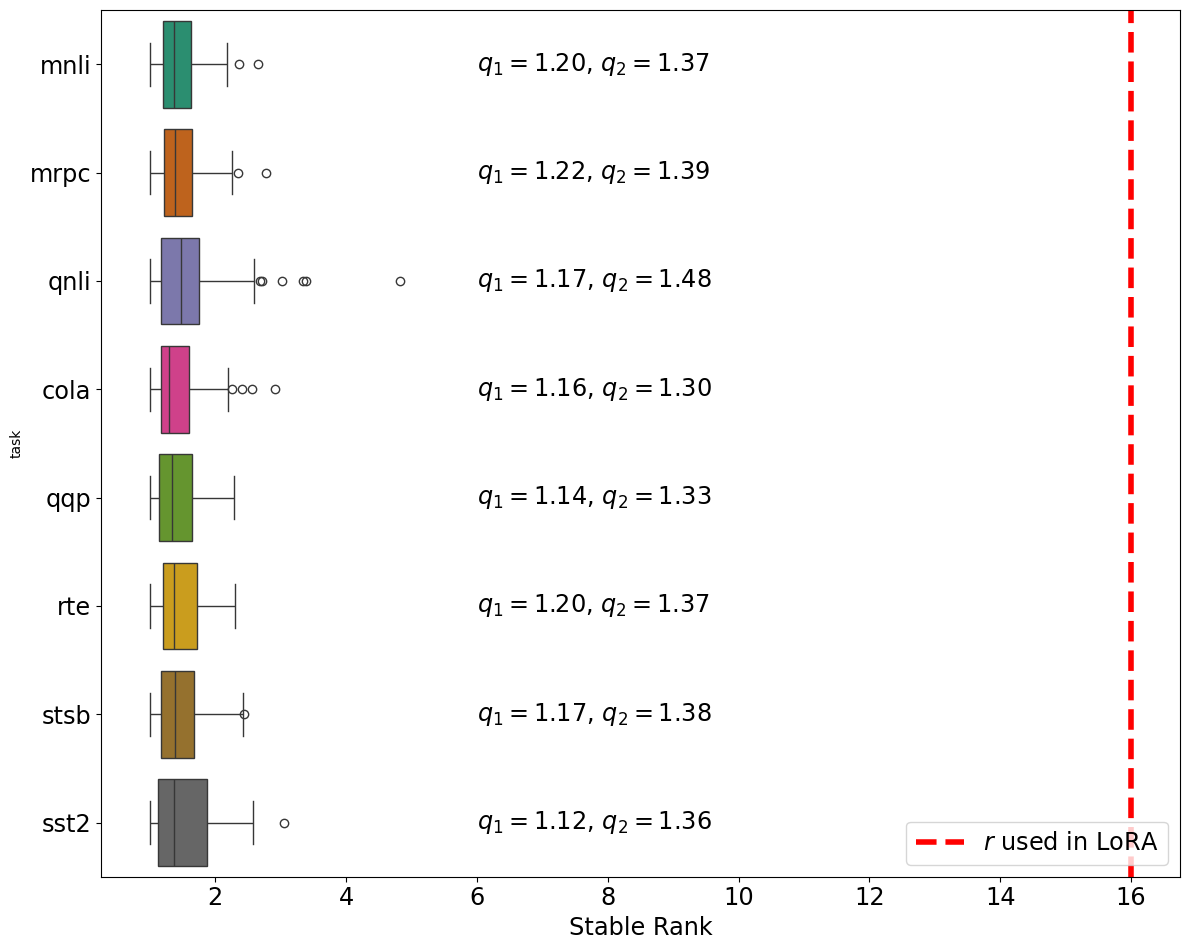

In [ ]:
figsize = (12, 1.2 * len(df['task'].unique()))
plt.figure(figsize=figsize)
boxplot = sns.boxplot(df, x='sr', y='task', palette='Dark2')

plt.axvline(x=nominal_rank, linestyle='--', linewidth='4', color='red', label=r'$r$ used in LoRA')
#boxplot.set_yticklabels(boxplot.get_yticks(), size = 15)
plt.xlabel("Stable Rank", size='xx-large')
plt.legend(loc='lower right', prop={'size': 'xx-large'})
plt.yticks(fontsize='xx-large')
plt.xticks(fontsize='xx-large')
quartiles_25 = df.groupby('task')['sr'].quantile(0.25)
medians      = df.groupby('task')['sr'].median()
max_vals = df.groupby('task')['sr'].max()
print(medians)
task_order = boxplot.get_yaxis().get_majorticklabels()
task_order = [tick.get_text() for tick in task_order]

for i, task in enumerate(task_order):
    print(task)
    q1_val     = quartiles_25.loc[task]
    median_val = medians.loc[task]
    max_val = 6
    plt.text(
        max_val,
        i,
        r'$q_1=$' + f'{q1_val:.2f}, ' + r'$q_2=$' + f"{median_val:.2f}",
        va='center',
        color='black',
        size='xx-large',
    )
plt.tight_layout()
plt.savefig("boxplot-stable-rank-official-checkpoints.pdf")